In [11]:
#定义工具
from langchain.tools import BaseTool
from pydantic import BaseModel, Field
import datetime


class GetDateInput(BaseModel):
    # format: str = Field(default="%Y-%m-%d", description="日期格式")
    pass

class GetDate(BaseTool):
    name: str = Field(default="get_date")
    description: str = Field(default="这是一个获取日期的API，可以获取当前日期")
    # args_schema: Type[BaseModel] = GetDateInput

    def _run(self) -> str:
        return datetime.datetime.now().strftime('%Y-%m-%d')
    async def _arun(self) -> str:
        raise NotImplementedError("This tool does not support async")

In [17]:

#导入大模型
from langchain.chat_models import init_chat_model,openai
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("api_key")
base_url = os.getenv("base_url")

online_llm = init_chat_model(
    api_key=api_key,
    model="qwen-plus-latest",
    model_provider="openai",
    base_url=base_url,
    temperature=0
)

In [18]:
#将工具添加到大模型中
online_llm_tool = online_llm.bind_tools([GetDate()])

In [20]:
#导入建立 agent 的相关环境
from langchain.agents import initialize_agent, AgentType
from langchain.agents import Tool #定义工具信息的
from pydantic import BaseModel,Field
from langchain.tools import BaseTool
from typing import Type
import requests


time_agent = initialize_agent(
    [GetDate()],
    online_llm,
    AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True, # 处理解析错误
)

/var/folders/xh/fl5j9g1n5t79htj8yk1cswzh0000gn/T/ipykernel_25398/4155500191.py:10: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. See LangGraph documentation for more details: https://langchain-ai.github.io/langgraph/. Refer here for its pre-built ReAct agent: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/
  time_agent = initialize_agent(


In [21]:
time_agent.run("今天几号？")

/var/folders/xh/fl5j9g1n5t79htj8yk1cswzh0000gn/T/ipykernel_25398/2645833274.py:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  time_agent.run("今天几号？")




> Entering new AgentExecutor chain...
Action:
```
{
  "action": "get_date",
  "action_input": {}
}
```
Observation: 2025-06-01
Thought:Action:
```
{
  "action": "Final Answer",
  "action_input": "今天是2025年6月1日。"
}
```

> Finished chain.


'今天是2025年6月1日。'

In [20]:
#导入图相关环境
from langgraph.graph import  StateGraph
from typing import  TypedDict, Annotated, List
from langgraph.graph.message import  add_messages

In [21]:
#定义消息状态信息
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [32]:
#定义图信息
graph = StateGraph(State)


#定义节点函数，返回值是状态信息
def chat_node(state: State):

    result = online_llm_tool.invoke(state["messages"])
    return {"messages": result}

In [33]:
#添加节点
graph.add_node('chat', chat_node)

In [34]:
import json
from langchain_core.messages import ToolMessage  # 导入工具消息类，用于封装工具执行结果

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""
    # 功能说明：实现LangGraph中执行工具调用的节点，处理AI消息中的工具请求

    def __init__(self, tools: list) -> None:
        # 工具初始化：将工具列表转换为{工具名:工具对象}的字典结构
        self.tools_by_name = {tool.name: tool for tool in tools}  

    def __call__(self, inputs: dict):
        # 节点调用入口，inputs包含消息历史记录
        if messages := inputs.get("messages", []):
            message = messages[-1]  # 获取最新AI消息（含工具调用请求）
        else:
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:  # 遍历消息中的所有工具调用请求
            # 执行具体工具：根据工具名获取实例并传入参数
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 封装工具结果为ToolMessage，包含：
            # content: JSON序列化的执行结果
            # name: 工具标识（需与请求匹配）
            # tool_call_id: 调用ID（用于关联请求与响应）
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}  # 返回工具消息列表，供后续节点处理

# 使用示例
tool_node = BasicToolNode(tools=[GetDate()])  # 创建工具节点实例，绑定日期工具
graph.add_node("tools", tool_node)  # 将节点添加到LangGraph状态图中

In [35]:
from typing import Literal  # 类型标注模块，用于定义字面量类型

def route_tools(state: State) -> Literal["tools", "__end__"]:
    """
    工具路由决策函数，用于条件边(conditional_edge)判断：
    - 当最后一条消息包含工具调用时路由到ToolNode
    - 否则终止流程
    
    参数:
        state: 包含消息历史的状态对象，可以是列表或字典形式
    返回:
        "tools" 或 "__end__" 字面量，指示下一步节点
    """
    # 状态数据提取逻辑
    if isinstance(state, list):  # 处理列表形式的状态数据
        ai_message = state[-1]  # 获取最新AI消息
    elif messages := state.get("messages", []):  # 处理字典形式的状态数据
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # 工具调用检测逻辑
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 存在工具调用时路由到工具节点
    return "__end__"  # 否则终止流程

# 构建状态图的条件边（核心控制流）
graph.add_conditional_edges(
    "chat",  # 源节点名称
    route_tools,  # 路由判断函数
    {
        "tools": "tools",      # 当返回"tools"时跳转到tools节点
        "__end__": "__end__"   # 当返回"__end__"时终止流程
    }
)

# 工具节点执行后必须返回chat节点重新决策
graph.add_edge("tools", "chat")  

# 设置状态图入口节点
graph.set_entry_point("chat")  

# 编译生成可执行的工作流实例
graph_builder = graph.compile()  


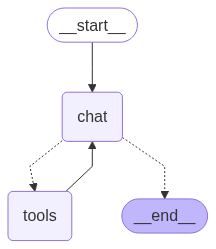

In [36]:
#可视化状态图
from IPython.display import Image, display

try:
    display(Image(graph_builder.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
event = graph_builder.invoke({"messages": [("user", "今日时间")]},stream_mode="debug")
event

[{'type': 'task',
  'timestamp': '2025-06-01T07:42:31.731209+00:00',
  'step': 1,
  'payload': {'id': 'ffa72157-b076-50f3-6407-3c9ddd414ecd',
   'name': 'chat',
   'input': {'messages': [HumanMessage(content='今日时间', additional_kwargs={}, response_metadata={}, id='f8a54438-5d3c-4d38-801d-73c2baeb212d')]},
   'triggers': ('branch:to:chat',)}},
 {'type': 'task_result',
  'timestamp': '2025-06-01T07:42:32.760442+00:00',
  'step': 1,
  'payload': {'id': 'ffa72157-b076-50f3-6407-3c9ddd414ecd',
   'name': 'chat',
   'error': None,
   'result': [('messages',
     AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_63e698fb3dd145b6a6f2ba', 'function': {'arguments': '{}', 'name': 'get_date'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 141, 'total_tokens': 156, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': '

In [41]:
# 执行工作流
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph_builder.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"], BaseMessage):
                print("Assistant:", value)


Assistant: {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_addc77c39d324797b5de5f', 'function': {'arguments': '{}', 'name': 'get_date'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 141, 'total_tokens': 156, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': 'chatcmpl-52d50e51-bb76-98db-b13c-da9a20ddda1d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-574187bf-01ef-4d02-8baa-9a354a4cf991-0', tool_calls=[{'name': 'get_date', 'args': {}, 'id': 'call_addc77c39d324797b5de5f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 141, 'output_tokens': 15, 'total_tokens': 156, 'input_token_details': {}, 'output_token_details': {}})}
Assistant: {'messages': AIMessage(content='今天是2025年6月1日。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens'